In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from math import sqrt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#import our scripts that do data science workflow
import env 
import wrangle
import split_scale
import evaluate
import features
import util

In [2]:
df = wrangle.wrangle_telco()
util.tell_me_about(df)

DataFrame Shape:

(1685, 3)

Info about:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1694
Data columns (total 3 columns):
monthly_charges    1685 non-null float64
total_charges      1685 non-null float64
tenure             1685 non-null int64
dtypes: float64(2), int64(1)
memory usage: 52.7 KB
None

Describe:

       monthly_charges  total_charges      tenure
count      1685.000000    1685.000000  1685.00000
mean         60.872374    3728.933947    57.07181
std          34.712210    2571.252806    17.72913
min          18.400000      20.350000     1.00000
25%          24.050000    1278.800000    48.00000
50%          64.450000    3623.950000    64.00000
75%          90.550000    5999.850000    71.00000
max         118.750000    8672.450000    72.00000

Preview:

   monthly_charges  total_charges  tenure
0           109.70        7904.25      71
1            84.65        5377.80      63
2            90.45        5957.90      65
3            45.20        2460.55 

In [3]:
train, test = split_scale.split_my_data(df)

In [4]:
scaler, train_scaled, test_scaled = split_scale.standard_scaler(train, test)

In [5]:
train_scaled.head()
test_scaled.head()

,monthly_charges,total_charges,tenure
305,-1.163401,-0.870704,0.844077
452,1.450002,1.488589,0.557416
917,1.389560,1.287299,0.328087
1421,-1.193622,-0.978302,0.385419
1557,-1.059786,-1.226585,-1.907870


In [11]:
x_train=train_scaled.drop(columns=['total_charges'])
x_test=test_scaled.drop(columns=['total_charges'])
y_train=train[['total_charges']]
y_test=test[['total_charges']]

In [12]:
features.optimal_number_of_features(x_train,y_train)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(2, 0.9635878360528035)

In [13]:
features.optimal_features(x_train,x_test,y_train,2)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(Index(['monthly_charges', 'tenure'], dtype='object'),
       monthly_charges    tenure
 0            0.419607  0.729412
 1           -1.169158 -0.130571
 2            1.385242  0.442751
 3            1.075836  0.729412
 4            1.592472  0.786745
 5            1.462954  0.614748
 6           -0.098468 -0.015907
 7           -0.610787 -0.417232
 8            1.343508  0.270754
 9            0.284332  0.614748
 10           0.238281  0.557416
 11          -1.025248  0.213422
 12           1.229820  0.844077
 13          -1.005100  0.672080
 14           0.292967  0.786745
 15          -1.051152  0.213422
 16          -1.179231  0.672080
 17          -1.173475 -0.417232
 18          -1.156206  0.041426
 19          -0.055295  0.328087
 20           0.435437  0.786745
 21          -1.173475 -0.417232
 22          -1.159084 -0.015907
 23          -1.018052  0.844077
 24          -1.176353 -0.531897
 25          -1.141815 -1.563877
 26           0.085736 -0.302568
 27           0.50451

3. Fit 2 different linear models to your data.

In [14]:
predictions=pd.DataFrame({'actual':y_train.total_charges}).reset_index(drop=True)
#model 1
lm1=LinearRegression()
lm1.fit(x_train[['monthly_charges','tenure']],y_train)
lm1_predictions=lm1.predict(x_train[['monthly_charges','tenure']])
predictions['lm1']=lm1_predictions

#model 2
lm2=LinearRegression()
lm2.fit(x_train[['tenure']],y_train)
lm2_predictions=lm2.predict(x_train[['tenure']])
predictions['lm2']=lm2_predictions

#baseline model
predictions['baseline'] = y_train.mean()[0]
predictions.head()
#print(lm1.intercept_,lm1.coef_)

,actual,lm1,lm2,baseline
0,5212.65,5173.164121,4922.684960,3740.536907
1,1079.05,1159.860706,3528.922066,3740.536907
2,7108.20,7011.897800,4458.097328,3740.536907
3,6859.50,6567.278343,4922.684960,3740.536907
4,8564.75,7707.376200,5015.602486,3740.536907


4. Evaluate the 2 models and your baseline

In [15]:
MSE_baseline = mean_squared_error(predictions.actual, predictions.baseline)
SSE_baseline = MSE_baseline*len(predictions.actual)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predictions.actual, predictions.baseline)
print(MSE_baseline,SSE_baseline,RMSE_baseline,r2_baseline)

6608313.117141245 8908006081.906399 2570.6639448090536 2.220446049250313e-16


In [16]:
MSE_1 = mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print(MSE_1,SSE_1,RMSE_1,r2_1)

240622.9806357559 324359777.89699894 490.53336342776515 0.9635878360528035


In [17]:
MSE_2 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_2 = MSE_2*len(predictions.actual)
RMSE_2 = sqrt(MSE_2)
r2_2 = r2_score(predictions.actual, predictions.lm2)
print(MSE_2,SSE_2,RMSE_2,r2_2)

3981691.454452978 5367320080.602614 1995.4176140479913 0.3974723376643726


5. Select the one that performed the best.

    The model with monthly charges and tenure performed the best



6. Apply your test data

In [18]:
model=lm1.predict(X_test[['monthly_charges','tenure']])
model=model.ravel().reshape(337)
y_test1=np.array(y_test).ravel().reshape(337)
best_model=pd.DataFrame({'predictions':model,'total_charges':y_test1})

best_model.head()

,predictions,total_charges
0,1895.246555,1502.25
1,7234.552129,7567.20
2,6935.992336,7049.75
3,1490.734855,1225.65
4,73.515425,587.40


7. Write a function that creates the model object, fits and predicts, given x_train, x_test, y_train, y_test¶


In [19]:
x_train1=x_train[['monthly_charges','tenure']]
x_test1=x_test[['monthly_charges','tenure']]
def modeling_function(x_train,x_test,y_train,y_test):
    predictions_train=pd.DataFrame({'actual':y_train.total_charges}).reset_index(drop=True)
    predictions_test=pd.DataFrame({'actual':y_test.total_charges}).reset_index(drop=True)
    #model 1
    lm1=LinearRegression()
    lm1.fit(x_train,y_train)
    lm1_predictions=lm1.predict(x_train)
    predictions_train['lm1']=lm1_predictions

    #model 2
    lm2=LinearRegression()
    lm2.fit(x_test,y_test)
    lm2_predictions=lm2.predict(x_test)
    predictions_test['lm2']=lm2_predictions
    
    return predictions_train,predictions_test

In [22]:
model_train,model_test=modeling_function(x_train1,x_test1,y_train,y_test)
model_train.head()
model_test.head()

,actual,lm2
0,1502.25,1859.384825
1,7567.20,7205.810102
2,7049.75,6917.225703
3,1225.65,1474.643543
4,587.40,155.709325


8. Write a function, plot_residuals(x, y, dataframe) that takes the feature, the target, and the dataframe as input and returns a residual plot.¶


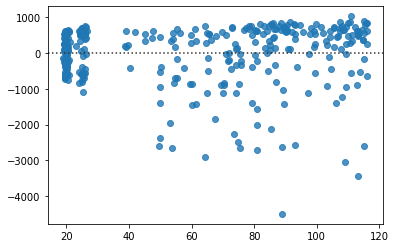

In [23]:
def plot_residuals(x, y):
    '''
    Plots the residuals of a model that uses x to predict y. Note that we don't
    need to make any predictions ourselves here, seaborn will create the model
    and predictions for us under the hood with the `residplot` function.
    '''
    return sns.residplot(x, y)

x=test[['monthly_charges']]
y=test[['total_charges']]
plot_residuals(x,y)

9.) Write a function, plot_regression(x, y) that takes a feature and a target and returns the datapoints, the regression line, and the confidence interval.


In [24]:
res = sm.OLS(y, x).fit()


In [25]:
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          total_charges   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                              8034.
Date:                Thu, 17 Oct 2019   Prob (F-statistic):                   1.13e-236
Time:                        18:18:36   Log-Likelihood:                         -2770.5
No. Observations:                 337   AIC:                                      5543.
Df Residuals:                     336   BIC:                                      5547.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
monthly_charges    63.0114      0.703     89.632      0.000      61.629      64.394
==============================================================================
Omnibus:                       83.921   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.009
Skew:                          -1.297   Prob(JB):                     1.21e-37
Kurtosis:                       5.319   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

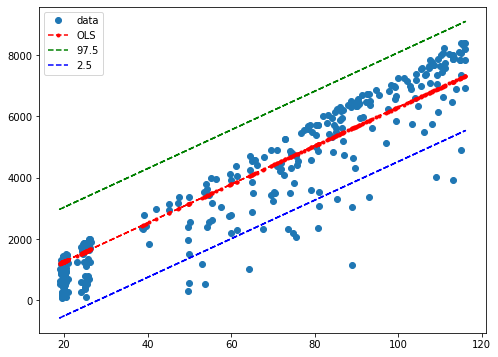

In [26]:
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="data")
#ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'g--',label='97.5')
ax.plot(x, iv_l, 'b--',label='2.5')
ax.legend(loc='best');

In [27]:
def plot_regression(x,y):
    res = sm.OLS(y, x).fit()
    prstd, iv_l, iv_u = wls_prediction_std(res)

    fig, ax = plt.subplots(figsize=(8,6))

    ax.plot(x, y, 'o', label="data")
    #ax.plot(x, y, 'b-', label="True")
    ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
    ax.plot(x, iv_u, 'g--',label='97.5% Confidence Level')
    ax.plot(x, iv_l, 'b--',label='2.5% Confidence Level')
    ax.legend(loc='best');
    plt.show()

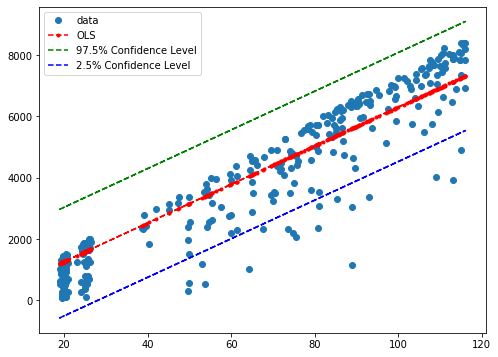

In [28]:
plot_regression(x,y)
